In [1]:
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cinic_tar_path = '/content/drive/MyDrive/CINIC-10.tar.gz'

In [4]:
dataset_tar = tarfile.open(cinic_tar_path)
dataset_tar.extractall('./cinic10root')
dataset_tar.close()

In [ ]:
cinic_root_dir = './cinic10root'
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

In [ ]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cinic_mean,std=cinic_std)])

In [ ]:
train_data = ImageFolder(cinic_root_dir + '/train', transform=tf)
valid_data = ImageFolder(cinic_root_dir + '/valid', transform=tf)
test_data = ImageFolder(cinic_root_dir + '/test', transform=tf)

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

Text(0.5, 0.98, 'CINIC-10 dataset')

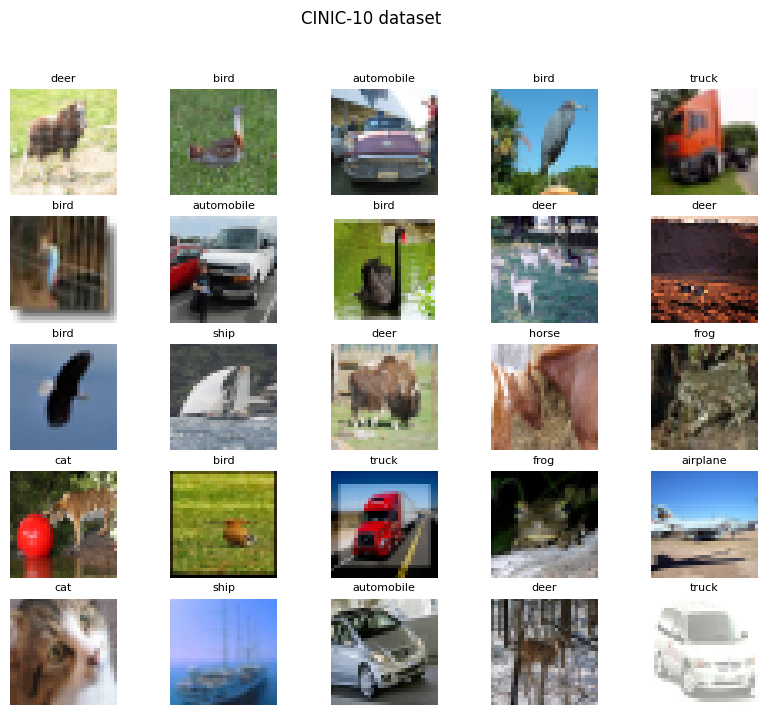

In [ ]:
from random import sample

examples = sample(test_data.imgs, 25)

fig = plt.figure(figsize=(10, 8))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
  plt.subplot(n_rows, n_cols, index)
  plt.axis('off')
  plt.imshow(test_data.loader(examples[index - 1][0]))
  title = f'{test_data.classes[examples[index - 1][1]]}'
  plt.title(title, fontsize=8)
plt.suptitle('CINIC-10 dataset')

In [ ]:
def test(model, test_loader, loss_fn, device):
  checkpoint = torch.load('./checkpt.tar')
  model.load_state_dict(checkpoint['model_state_dict'])
  model.eval()
  running_loss = 0
  num_correct_pred = 0

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat = model(X)

    loss = loss_fn(y_hat, y_true)

    pred_labels = torch.argmax(y_hat, 1)
    num_correct_pred += (pred_labels == y_true).sum()

    running_loss += loss.item() * X.size(0)
  
  test_loss = running_loss / len(test_loader.dataset)
  test_accuracy = num_correct_pred / len(test_loader.dataset)
  return model, test_loss, test_accuracy

In [ ]:
'''
  ResNet18 from a popular repository
  url:https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
  Modification:
  * a dropout layer for randomization
'''

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

'''
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
'''

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                           stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    # dropout for mc-uncertainty
    self.dr = nn.Dropout(0.5)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.dr(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = ResNet18().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/resnet.pth'))

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=initial_lr,
                      momentum=0.9, weight_decay=5e-4)

In [ ]:
model, test_loss, test_accuracy = test(model, test_loader, loss_fn, device)
print('Accuracy on clean samples:{test_accuracy * 100:.2f}%')

In [ ]:
def gn(images, std):
  noisy_images = images + std * torch.randn_like(images)
  noisy_images = torch.clamp(noisy_images, min=-1, max=1)

  return noisy_images

In [ ]:
# implementation of fgsm attack based on torchattacks(https://github.com/Harry24k/adversarial-attacks-pytorch)

def fgsm(model, loss_fn, images, labels, eps):
  images = images.clone().detach()
  labels = labels.clone().detach()

  images.requires_grad = True
  outputs = model(images)
  cost = loss_fn(outputs, labels)
  grad = torch.autograd.grad(cost, images,
                                   retain_graph=False, create_graph=False)[0]
  
  adv_images = images + eps * grad.sign()
  adv_images = torch.clamp(adv_images, min=-1, max=1)

  return adv_images

In [ ]:
# implementation of BIM attack based on torchattacks(https://github.com/Harry24k/adversarial-attacks-pytorch)

def bim(model, loss_fn, images, labels, eps, alpha, steps):
  #images = images.clone().detach().to(device)
  #labels = labels.clone().detach().to(device)

  original_images = images.clone().detach()
  images_min = original_images - eps
  images_max = original_images + eps

  images.requires_grad = True

  for i in range(steps):
    outputs, _ = model(images)

    cost = loss_fn(outputs, labels)
    grad = torch.autograd.grad(cost, images, retain_graph=False, create_graph=False)[0]

    adv_images = images + alpha * grad.sign()
    adv_images = torch.clamp(adv_images, min=images_min, max=images_max)
    images = torch.clamp(adv_images, min=0, max=1)

  return images

In [ ]:
# implememntation of JSMA attack based on torchattacks(https://github.com/Harry24k/adversarial-attacks-pytorch)

def jsma(model, images, labels, theta, gamma):
  images = images.clone().detach()
  labels = labels.clone().detach()

  target_labels = (labels + 1) % 10

  for im, tl in zip(images, target_labels):
    pert_image = perturbation_single(
          model, torch.unsqueeze(im, 0), torch.unsqueeze(tl, 0), theta)
    try:
      adv_images = torch.cat((adv_images, pert_image), 0)
    except Exception:
      adv_images = pert_image

  adv_images = torch.clamp(adv_images, min=0, max=1)
  return adv_images

def perturbation_single(model, image, target_label, theta):
  var_image = image
  var_label = target_label
  # var_image = var_image.to(self.device)
  # var_label = var_label.to(self.device)

  if theta > 0:
    increasing = True
  else:
    increasing = False

  num_features = int(torch.prod(var_image.shape[1:]))
  shape = var_image.shape

  # Perturb two pixels in one iteration, thus max_iters is divided by 2
  max_iters = int(torch.ceil(num_features * self.gamma / 2.0))

  # Masked search domain, if the pixel has already reached the top or bottom, we don't bother to modify it
  if increasing:
    search_domain = torch.lt(var_image, 0.99)
  else:
    search_domain = torch.gt(var_image, 0.01)

  search_domain = search_domain.view(num_features)
  output = model(var_image)
  current_pred = torch.argmax(output.data, 1)

  iter = 0
  while (iter < max_iters) and (current_pred != target_label) and (search_domain.sum() != 0):
    # Calculate Jacobian matrix of forward derivative
    jacobian = compute_jacobian(model, var_image)
    # Get the saliency map and calculate the two pixels that have the greatest influence
    p1, p2 = saliency_map(jacobian, var_label,
                          increasing, search_domain, num_features)
    # Apply modifications
    # var_sample_flatten = var_image.view(-1, num_features).clone().detach_()
    var_sample_flatten = var_image.view(-1, num_features)
    var_sample_flatten[0, p1] += theta
    var_sample_flatten[0, p2] += theta

    new_image = torch.clamp(var_sample_flatten, min=0.0, max=1.0)
    new_image = new_image.view(shape)
    search_domain[p1] = 0
    search_domain[p2] = 0
    # var_image = new_image.clone().detach().to(self.device)
    # var_image = new_image.to(self.device)
    var_image = new_image.clone().detach()

    output = model(var_image)
    current_pred = torch.argmax(output.data, 1)
    iter += 1

  adv_image = var_image
  return adv_image

def compute_jacobian(model, image):
    var_image = image.clone().detach()
    var_image.requires_grad = True
    output = model(var_image)

    num_features = int(torch.prod(var_image.shape[1:]))
    jacobian = torch.zeros([output.shape[1], num_features])
    for i in range(output.shape[1]):
      if var_image.grad is not None:
        var_image.grad.zero_()
      output[0][i].backward(retain_graph=True)
      # Copy the derivative to the target place
      jacobian[i] = var_image.grad.squeeze().view(-1, num_features).clone()  # nopep8

    return jacobian

def saliency_map(jacobian, target_label, increasing, search_space, nb_features):
  # The search domain
  domain = torch.eq(search_space, 1).float()
  # The sum of all features' derivative with respect to each class
  all_sum = torch.sum(jacobian, dim=0, keepdim=True)
  # The forward derivative of the target class
  target_grad = jacobian[target_label]
  # The sum of forward derivative of other classes
  others_grad = all_sum - target_grad

  # This list blanks out those that are not in the search domain
  if increasing:
      increase_coef = 2 * (torch.eq(domain, 0)).float().to(self.device)
  else:
      increase_coef = -1 * 2 * \
          (torch.eq(domain, 0)).float().to(self.device)
  increase_coef = increase_coef.view(-1, nb_features)

  # Calculate sum of target forward derivative of any 2 features.
  target_tmp = target_grad.clone()
  target_tmp -= increase_coef * torch.max(torch.abs(target_grad))
  # PyTorch will automatically extend the dimensions
  alpha = target_tmp.view(-1, 1, nb_features) + \
      target_tmp.view(-1, nb_features, 1)
  # Calculate sum of other forward derivative of any 2 features.
  others_tmp = others_grad.clone()
  others_tmp += increase_coef * torch.max(torch.abs(others_grad))
  beta = others_tmp.view(-1, 1, nb_features) + \
      others_tmp.view(-1, nb_features, 1)

  # Zero out the situation where a feature sums with itself
  tmp = torch.ones((nb_features, nb_features), int)
  torch.Tensor.fill_diagonal(tmp, 0)
  zero_diagonal = torch.from_numpy(tmp).byte().to(self.device)

  # According to the definition of saliency map in the paper (formulas 8 and 9),
  # those elements in the saliency map that doesn't satisfy the requirement will be blanked out.
  if increasing:
      mask1 = torch.gt(alpha, 0.0)
      mask2 = torch.lt(beta, 0.0)
  else:
      mask1 = torch.lt(alpha, 0.0)
      mask2 = torch.gt(beta, 0.0)

  # Apply the mask to the saliency map
  mask = torch.mul(torch.mul(mask1, mask2), zero_diagonal.view_as(mask1))
  # Do the multiplication according to formula 10 in the paper
  saliency_map = torch.mul(
      torch.mul(alpha, torch.abs(beta)), mask.float())
  # Get the most significant two pixels
  max_idx = torch.argmax(
      saliency_map.view(-1, nb_features * nb_features), dim=1)
  # p = max_idx // nb_features
  p = torch.div(max_idx, nb_features, rounding_mode='floor')
  # q = max_idx % nb_features
  q = max_idx - p * nb_features
  return p, q

In [ ]:
def run_gn(model, test_loader, std, device):
  num_correct = 0

  model.eval()

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)
    pert_data = gn(X, std)
    with torch.no_grad():
      y_hat, y_hat_probs = model(pert_data)
    y_labels = torch.argmax(y_hat_probs, 1)

    num_correct += (y_labels == y_true).sum()

  noisy_accuracy = num_correct / len(test_loader.dataset)

  return model, noisy_accuracy

In [ ]:
def run_fgsm(model, loss_fn, test_loader, eps, device):
  num_correct = 0
  diff = torch.empty(0)

  model.eval()

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)
    pert_data = fgsm(model, loss_fn, X, y_true, eps, device)
    with torch.no_grad():
      y_hat, y_hat_probs = model(pert_data)
    y_labels = torch.argmax(y_hat_probs, 1)

    num_correct += (y_labels == y_true).sum()

    diff = torch.cat((diff, X.reshape((len(X), -1)).cpu() - pert_data.reshape((len(X), -1)).cpu()))

  adv_accuracy = num_correct / len(test_loader.dataset)
  pert_norm = torch.linalg.norm(diff, dim=1).mean()

  return model, adv_accuracy, pert_norm

In [ ]:
def run_bim(model, loss_fn, test_loader, eps, alpha, steps, device):
  num_correct = 0
  diff = torch.empty(0)

  model.eval()

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)
    pert_data = bim(model, loss_fn, X, y_true, eps, alpha, steps, device)
    with torch.no_grad():
      y_hat, y_hat_probs = model(pert_data)
    y_labels = torch.argmax(y_hat_probs, 1)

    num_correct += (y_labels == y_true).sum()

    diff = torch.cat((diff, X.reshape((len(X), -1)).cpu() - pert_data.reshape((len(X), -1)).cpu()))

  adv_accuracy = num_correct / len(test_loader.dataset)
  pert_norm = torch.linalg.norm(diff, dim=1).mean()

  return model, adv_accuracy, pert_norm

In [ ]:
def run_jsma(model, test_loader, theta, gamma, device):
  num_correct = 0
  diff = torch.empty(0)

  model.eval()

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)
    pert_data = jsma(model, X, y_true, theta, gamma)
    with torch.no_grad():
      y_hat, y_hat_probs = model(pert_data)
    y_labels = torch.argmax(y_hat_probs, 1)

    num_correct += (y_labels == y_true).sum()

    diff = torch.cat((diff, X.reshape((len(X), -1)).cpu() - pert_data.reshape((len(X), -1)).cpu()))

  adv_accuracy = num_correct / len(test_loader.dataset)
  pert_norm = torch.linalg.norm(diff, dim=1).mean()

  return model, adv_accuracy, pert_norm